1. Подготовка данных

1) проверить наличие пропусков и выбросов
2) привести категориальные признаки к числовым
3) вычислить парные корреляции признаков

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

trainDF = pd.read_csv('insurance_train.csv')
testDF = pd.read_csv('insurance_test.csv')
print('Train data head:')
display(trainDF.head())
print('Test data head:')
display(testDF.head())

Train data head:


,age,sex,bmi,children,smoker,region,charges
0,26,male,27.060,0,yes,southeast,17043.34140
1,58,male,36.955,2,yes,northwest,47496.49445
2,20,female,24.420,0,yes,southeast,26125.67477
3,51,female,38.060,0,yes,southeast,44400.40640
4,62,female,25.000,0,no,southwest,13451.12200


Test data head:


,age,sex,bmi,children,smoker,region,charges
0,61,male,38.380,0,no,northwest,12950.07120
1,59,female,34.800,2,no,southwest,36910.60803
2,31,male,30.875,0,no,northeast,3857.75925
3,24,female,33.345,0,no,northwest,2855.43755
4,31,male,28.500,5,no,northeast,6799.45800


In [4]:
print('Train shape:', trainDF.shape)
print('Test shape:', testDF.shape)

Train shape: (338, 7)
Test shape: (1000, 7)


In [5]:
print('\nПропуски в train:')
print(trainDF.isnull().sum())
print('\nПропуски в test:')
print(testDF.isnull().sum())


Пропуски в train:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Пропуски в test:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [6]:
num_cols = trainDF.select_dtypes(include=[np.number])
Q1 = num_cols.quantile(0.25)
Q3 = num_cols.quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = ((num_cols < (Q1 - 1.5 * IQR)) | (num_cols > (Q3 + 1.5 * IQR)))
print("Количество выбросов по IQR в train_data:")
print(outliers_iqr.sum())

Количество выбросов по IQR в train_data:
age          0
bmi          5
children     0
charges     19
dtype: int64



Колонки после кодирования:
['age', 'bmi', 'charges', 'children', 'region_northwest', 'region_southeast', 'region_southwest', 'sex_male', 'smoker_yes']


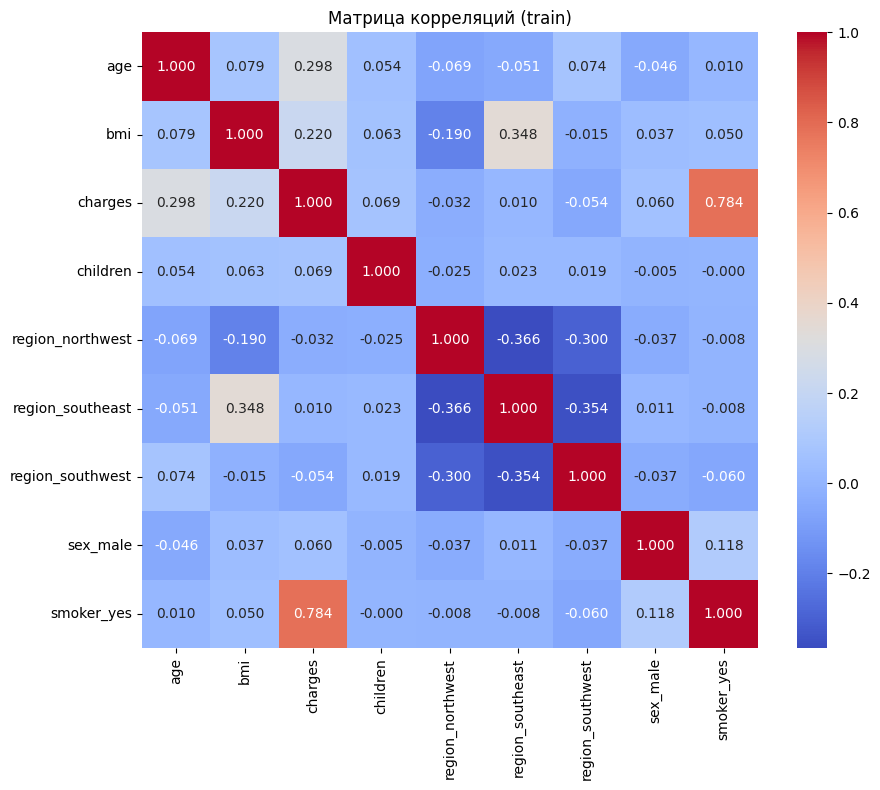

In [7]:
cat_cols = ['sex', 'smoker', 'region']
trainDF_enc = pd.get_dummies(trainDF, columns=cat_cols, drop_first=True)
testDF_enc = pd.get_dummies(testDF, columns=cat_cols, drop_first=True)

for col in trainDF_enc.columns:
    if col not in testDF_enc.columns:
        testDF_enc[col] = 0
for col in testDF_enc.columns:
    if col not in trainDF_enc.columns:
        trainDF_enc[col] = 0

df_enc = trainDF_enc.sort_index(axis=1)
df_test_enc = testDF_enc[df_enc.columns]

print('\nКолонки после кодирования:')
print(df_enc.columns.tolist())

# 1.5 Корреляции (парные)
plt.figure(figsize=(10,8))
sns.heatmap(df_enc.corr(), annot=True, fmt='.3f', cmap='coolwarm', square=True)
plt.title('Матрица корреляций (train)')
plt.show()

In [10]:
TARGET = 'charges'
X_train = df_enc.drop(columns=[TARGET]).values
y_train = df_enc[TARGET].values
X_test = df_test_enc.drop(columns=[TARGET]).values
y_test = df_test_enc[TARGET].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_f = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
X_test_f = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]

def analytical_solution(X, y, reg_lambda=0.0):

    m = X.shape[1]
    A = X.T @ X
    if reg_lambda > 0:
        L = reg_lambda * np.eye(m)
        L[0,0] = 0.0
        A = A + L
    theta = np.linalg.pinv(A) @ X.T @ y
    return theta

theta_analytic = analytical_solution(X_train_f, y_train, reg_lambda=0.0)
print('\nАналитические веса (без регуляризации):')
print(theta_analytic)


Аналитические веса (без регуляризации):
[14092.8619242   3495.76949182  2210.57176839   581.67513525
   -85.25913065  -638.00136585  -601.39012784  -327.42129485
  9859.84555479]


In [15]:
def gradient_descent(X, y, lr=0.01, n_iterations=5000, tol=1e-8, reg_lambda=0.0, verbose=False):
    n = X.shape[0]
    m = X.shape[1]
    theta = np.zeros(m)
    cost_history = []

    for i in range(n_iterations):
        y_pred = X @ theta
        error = y_pred - y

        cost = (1/(2*n)) * np.sum(error**2)
        if reg_lambda > 0:
            cost += (reg_lambda/(2*n)) * np.sum(theta[1:]**2)
        cost_history.append(cost)

        grad = (1/n) * (X.T @ error)
        if reg_lambda > 0:
            reg = (reg_lambda / n) * theta
            reg[0] = 0.0
            grad += reg

        theta -= lr * grad  
        
        if i > 0 and abs(cost_history[-2] - cost_history[-1]) < tol:
            if verbose:
                print(f"Early stop at iter {i}, Δcost={abs(cost_history[-2]-cost_history[-1]):.2e}")
            break     

    return theta, cost_history


theta_gd, cost_hist = gradient_descent(X_train_f, y_train, lr=0.1, n_iterations=20000, tol=1e-9, reg_lambda=0.0, verbose=True)
print('\nВеса (градиентный спуск):')
print(theta_gd)

Early stop at iter 433, Δcost=0.00e+00

Веса (градиентный спуск):
[14092.8619242   3495.76953719  2210.57164319   581.67513084
   -85.25875431  -638.00090895  -601.38973915  -327.42126023
  9859.84559949]



MSE на train: аналитик = 44325092.02597582
MSE на train: gd = 44325092.02597598


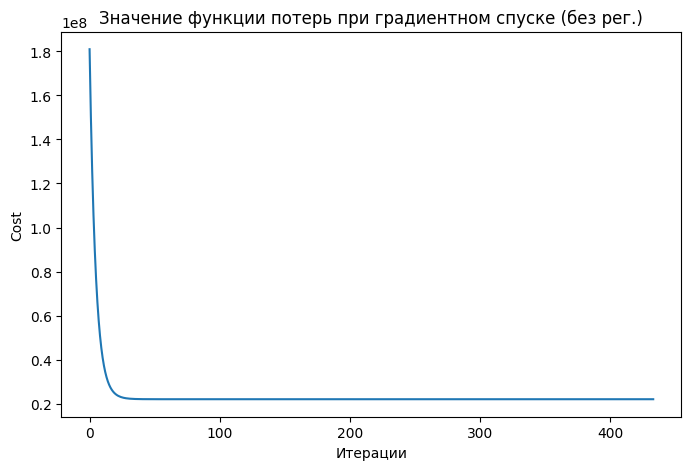

In [16]:
y_train_pred_analytic = X_train_f @ theta_analytic
y_train_pred_gd = X_train_f @ theta_gd
print('\nMSE на train: аналитик =', mean_squared_error(y_train, y_train_pred_analytic))
print('MSE на train: gd =', mean_squared_error(y_train, y_train_pred_gd))

plt.figure(figsize=(8,5))
plt.plot(cost_hist)
plt.title('Значение функции потерь при градиентном спуске (без рег.)')
plt.xlabel('Итерации')
plt.ylabel('Cost')
plt.show()


Аналитические веса Ridge (alpha= 100.0 ):
[14092.8619242   2758.25309584  1765.78714083   495.51097425
   -64.94327809  -368.06072422  -442.96288329   -59.98094034
  7616.36496357]
Early stop at iter 211, Δcost=0.00e+00

Веса Ridge (gd):
[14092.86192139  2758.25312153  1765.78706996   495.51097176
   -64.94306507  -368.06046561  -442.96266328   -59.98092072
  7616.36498886]


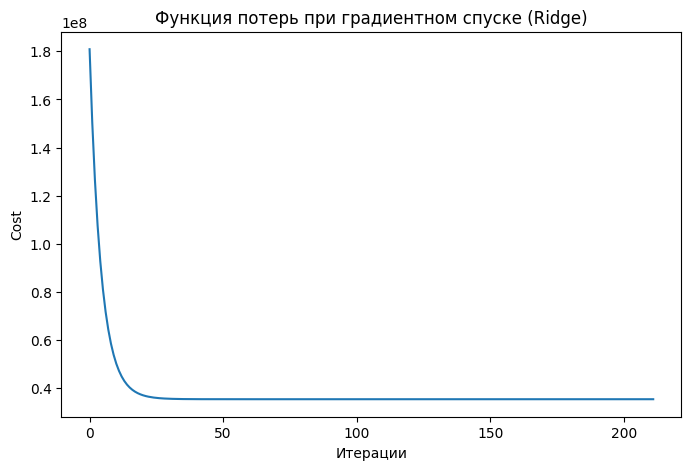

In [17]:
alpha = 100.0
theta_ridge_analytic = analytical_solution(X_train_f, y_train, reg_lambda=alpha)
print('\nАналитические веса Ridge (alpha=', alpha, '):')
print(theta_ridge_analytic)

theta_ridge_gd, cost_ridge_hist = gradient_descent(X_train_f, y_train, lr=0.1, n_iterations=20000, reg_lambda=alpha, tol=1e-9, verbose=True)
print('\nВеса Ridge (gd):')
print(theta_ridge_gd)

plt.figure(figsize=(8,5))
plt.plot(cost_ridge_hist)
plt.title('Функция потерь при градиентном спуске (Ridge)')
plt.xlabel('Итерации')
plt.ylabel('Cost')
plt.show()

In [19]:
results = {}
# 4.1 Константная модель: прогноз средним значением charges на train
mean_train = y_train.mean()
print('\nСреднее charges на train =', mean_train)

y_pred_const = np.full_like(y_test, fill_value=mean_train, dtype=float)
mse_const = mean_squared_error(y_test, y_pred_const)
results['Константная модель (mean train)'] = mse_const

# 4.2 Аналитическая линейная регрессия
y_pred_linear_analytic = X_test_f @ theta_analytic
mse_linear_analytic = mean_squared_error(y_test, y_pred_linear_analytic)
results['Линейная регрессия (аналитическая)'] = mse_linear_analytic

# 4.3 Градиентный спуск (линейная)
y_pred_linear_gd = X_test_f @ theta_gd
mse_linear_gd = mean_squared_error(y_test, y_pred_linear_gd)
results['Линейная регрессия (GD)'] = mse_linear_gd

# 4.4 Ridge аналитический
y_pred_ridge_analytic = X_test_f @ theta_ridge_analytic
mse_ridge_analytic = mean_squared_error(y_test, y_pred_ridge_analytic)
results['Ridge (аналитическая)'] = mse_ridge_analytic

# 4.5 Ridge GD
y_pred_ridge_gd = X_test_f @ theta_ridge_gd
mse_ridge_gd = mean_squared_error(y_test, y_pred_ridge_gd)
results['Ridge (GD)'] = mse_ridge_gd

results_df = pd.DataFrame(list(results.items()), columns=['Модель', 'MSE на тесте'])
print('\nРезультаты на тесте:')
print(results_df)


Среднее charges на train = 14092.861924201185

Результаты на тесте:
                               Модель  MSE на тесте
0     Константная модель (mean train)  1.418301e+08
1  Линейная регрессия (аналитическая)  3.421601e+07
2             Линейная регрессия (GD)  3.421601e+07
3               Ridge (аналитическая)  4.024463e+07
4                          Ridge (GD)  4.024463e+07
